![logo](./img/LogoLine_horizon_C3S.png)

<br>

# Preprocess ERA5

### About

### Install packages

In [1]:
# Miscellaneous operating system interfaces
import os

# CDS API
import cdsapi

# To map GRIB files to NetCDF Common Data Model
import cfgrib

# Libraries for working with multi-dimensional arrays
import numpy as np
import xarray as xr
import pandas as pd
import scipy

# Libraries for plotting and geospatial data visualisation
import matplotlib.path as mpath
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

# To work with data labels in dictionary format
from collections import OrderedDict

# Date and time related libraries
from dateutil.relativedelta import relativedelta
from calendar import monthrange
import datetime

# Interactive HTML widgets
import ipywidgets as widgets

# Disable warnings for data download via API
import urllib3 
urllib3.disable_warnings()

In [5]:
DATADIR = 'C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/reanalysis'

## 1. Air temperature

In [6]:
# Define the coordinates to interpolate to
interp_longitude=2.25 #C1=C2=2.25
interp_latitude=42.3  #C1=42.3, C2=42.05
variable_name = '2m_temperature'
var_short = 't2m'

In [9]:
daily_data_list_t2m = []

for year_num in range(2023,2025):

    era5 = xr.open_dataset(f'{DATADIR}/ecmwf_era5_'+ str(year_num) + '_hourly_' + var_short + '.grib', engine='cfgrib')
    
    era5_var = era5[var_short]

    #Interpolate the values for the specified coordinates
    hind_interp = era5_var.interp(latitude=interp_latitude, longitude=interp_longitude, method="nearest")

    #From hourly to daily 
    era5_24h = hind_interp.resample(time='1D').mean()
    daily_data_list_t2m.append(era5_24h)

#Merge years
era5_24h_all_t2m = xr.concat(daily_data_list_t2m, dim='time')

In [ ]:
era5_24h_all_t2m

## 2. Total Precipitation

In [13]:
# Define the coordinates to interpolate to
interp_longitude=2.25 #reach1=reach2=2.25
interp_latitude=42.3  #reach1=42.3, reach2=42.05
variable_name = 'total_precipitation'
var_short = 'tp'

In [15]:
daily_data_list_tp = []

for year_num in range(2023,2025):
    
    #convert data from hourly to daily
    #!cdo daysum {DATADIR + 'ecmwf_era5_'+ str(year_num) + '_hourly_' + var_short + '.grib'} {DATADIR + 'daily/ecmwf_era5_'+ str(year_num) + '_daily_' + var_short + '.grib'}

    era5 = xr.open_dataset(f'{DATADIR}/daily_tp/ecmwf_era5_'+ str(year_num) + '_daily_' + var_short + '.grib', engine='cfgrib')
    
    era5_var = era5[var_short]

    #Interpolate the values for the specified coordinates
    era5_interp = era5_var.interp(latitude=interp_latitude, longitude=interp_longitude, method="nearest")

    #From hourly to daily 
    #era5_24h = hind_interp.resample(time='1D').mean()
    daily_data_list_tp.append(era5_interp)

#Merge years
era5_24h_all_tp = xr.concat(daily_data_list_tp, dim='time')


#era5 = xr.open_dataset(f'{DATADIR}/ecmwf_era5_'+ str(year_num) + '_daily_' + var_short + '.grib', engine='cfgrib')
    
#era5_var = era5[var_short]

    #Interpolate the values for the specified coordinates
#era5_interp = era5_var.interp(latitude=interp_latitude, longitude=interp_longitude, method="nearest")
  
    #From hourly to daily 
#era5_24h = era5_interp.resample(time='1D').sum()
#era5_var.resample(time='1D',closed='right').sum()

Can't create file 'C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/reanalysis/daily_tp/ecmwf_era5_2023_daily_tp.grib.5b7b6.idx'
Traceback (most recent call last):
  File "C:\Users\apedregal\Anaconda3\lib\site-packages\cfgrib\messages.py", line 537, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
  File "C:\Users\apedregal\Anaconda3\lib\contextlib.py", line 119, in __enter__
    return next(self.gen)
  File "C:\Users\apedregal\Anaconda3\lib\site-packages\cfgrib\messages.py", line 503, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/reanalysis/daily_tp/ecmwf_era5_2023_daily_tp.grib.5b7b6.idx'
Can't read index file 'C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/reanalysis/daily_tp/ecmwf_era5_2023_daily_tp.grib.5b7b6.id

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/reanalysis/daily_tp/ecmwf_era5_2023_daily_tp.grib'

In [13]:
data_save = {'tp': era5_24h_all_tp.values*1000,'t2m': era5_24h_all_t2m.values-273.15}

In [14]:
df_save = pd.DataFrame(data_save)

In [15]:
df_save

,tp,t2m
0,0.000000,2.732178
1,0.000000,4.194855
2,2.531528,3.065857
3,0.000000,3.681641
4,0.000000,4.415924
...,...,...
2187,0.000000,-6.231445
2188,0.191212,-4.423431
2189,1.136303,-1.109283
2190,0.000000,2.643677


Saving csv files

In [42]:
#set reach number
reach = 'C1' #subcatchments: reach1=C1, reach2=C2 (DEPENDS ON THE INTERPOLATION COORDINATES)

In [15]:
# Saving as CSV
# tp and t2m merged without dates
filename = f'reanalysis_daily_all_{reach}.csv'
df_save.to_csv(filename, index=False, sep=' ')

In [52]:
#tp with dates
df_tp = pd.DataFrame({'time': era5_24h_all_tp.time, 'values': era5_24h_all_tp.values*1000})
filename = f'reanalysis_daily_tp_{reach}.csv'
df_tp.to_csv(filname, index=False, sep=' ')

In [53]:
#t2m with dates
df_t2m = pd.DataFrame({'time': era5_24h_all_t2m.time, 'values': era5_24h_all_t2m-273.15})
filename = f'reanalysis_daily_t2m_{reach}.csv'
df_t2m.to_csv(filename, index=False, sep=' ')

In [43]:
#tp and t2m with dates (this file is used to merge it with hindcast data)
df_tp_t2m = pd.DataFrame({'time': era5_24h_all_t2m.time, 'tp': era5_24h_all_tp.values*1000, 't2m': era5_24h_all_t2m-273.15})
filename = f'reanalysis_daily_{reach}_all_withDates.csv'
df_tp_t2m.to_csv(filename, index=False, sep=' ')

In [28]:
#check wd
import os
print(os.getcwd())

C:\Users\apedregal\Documents\inventWater_docs\Modelling\Seasonal forecasts\Daniel\Github\ForecastHydroCarbon-main


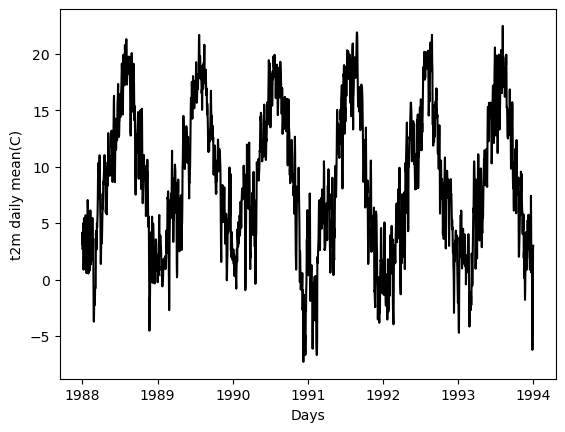

In [44]:
#plotting
plt.plot(era5_24h_all_t2m.time, era5_24h_all_t2m-273.15, color='black')

# Add labels and title
plt.xlabel('Days')
plt.ylabel('t2m daily mean(C)')
#plt.title('Data for each number')
#plt.legend()  # Add legend to differentiate lines
plt.show()

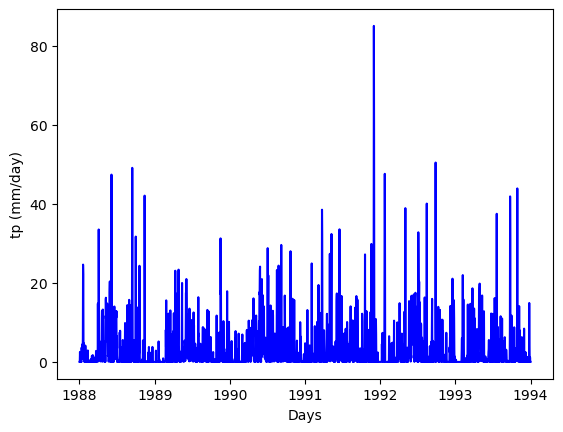

In [45]:
plt.plot(era5_24h_all_tp.time, era5_24h_all_tp.values*1000, color='blue')

# Add labels and title
plt.xlabel('Days')
plt.ylabel('tp (mm/day)')
#plt.title('Data for each number')
#plt.legend()  # Add legend to differentiate lines
plt.show()